# Importing Necesseties

In [73]:
!pip install -r ../resources/requirements.txt



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [186]:
import re
import string
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.corpus import stopwords

# Any results you write to the current directory are saved as output.

**Below is a helper Function which generates random colors which can be used to give different colors to your plots.Feel free to use it**

In [187]:
data = pd.read_csv('../../resources/data/english_tweet.csv')
data.drop(columns=['en_tweet', "Unnamed: 0"], inplace=True)
data

,label,tweet
0,anger,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu..."
1,anger,"Sesama cewe lho (kayaknya), harusnya bisa lebi..."
2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
3,anger,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng..."
4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata..."
...,...,...
4396,love,"Tahukah kamu, bahwa saat itu papa memejamkan m..."
4397,fear,Sulitnya menetapkan Calon Wapresnya Jokowi di ...
4398,anger,"5. masa depannya nggak jelas. lha iya, gimana ..."
4399,happy,[USERNAME] dulu beneran ada mahasiswa Teknik U...


In [188]:
import random


def random_deletion(words, p=0.2):
    """ Randomly delete words with probability p """
    if len(words) == 1:
        return words
    return [w for w in words if random.uniform(0, 1) > p]


def random_swap(words, n=1):
    """ Swap two words n times """
    words = words.copy()
    for _ in range(n):
        idx1, idx2 = random.sample(range(len(words)), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    return words


def random_insertion(words, n=1):
    """ Insert a random word from the sentence into a random position """
    words = words.copy()
    for _ in range(n):
        new_word = random.choice(words)
        insert_pos = random.randint(0, len(words))
        words.insert(insert_pos, new_word)
    return words


def augment_text(text):
    words = text.split()
    choice = random.choice(['delete', 'swap', 'insert'])

    if choice == 'delete':
        aug_words = random_deletion(words)
    elif choice == 'swap':
        aug_words = random_swap(words)
    elif choice == 'insert':
        aug_words = random_insertion(words)

    return " ".join(aug_words)


In [189]:
import random
from tqdm import tqdm


def augment_dataset(df, text_col="tweet", label_col="label", frac=0.49):
    """
    Augment a fraction of dataset rows and return a bigger dataset
    """
    # sample rows for augmentation
    sampled = df.sample(frac=frac, random_state=42)

    augmented_texts = []
    augmented_labels = []

    for _, row in tqdm(sampled.iterrows()):
        aug_text = augment_text(row[text_col])  # from previous code
        augmented_texts.append(aug_text)
        augmented_labels.append(row[label_col])

    # make augmented dataframe
    df_aug = pd.DataFrame({text_col: augmented_texts, label_col: augmented_labels})

    # concatenate with original
    df_new = pd.concat([df, df_aug], ignore_index=True)
    return df_new


df_augmented = augment_dataset(data)


2156it [00:00, 16028.66it/s]


In [190]:
indo_stop_words = stopwords.words(fileids='indonesian')
indo_stop_words.append("[USERNAME]")
indo_stop_words.append("url")

In [191]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    # text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


data['tweet'] = data['tweet'].apply(lambda x: clean_text(x))
data

,label,tweet
0,anger,Soal jln Jatibarupolisi tdk bs GERTAK gubernur...
1,anger,Sesama cewe lho kayaknya harusnya bisa lebih r...
2,happy,Kepingin gudeg mbarek Bu hj Amad Foto dari goo...
3,anger,Jln Jatibarubagian dari wilayah Tn AbangPengat...
4,happy,Sharing pengalaman aja kemarin jam batalin ti...
...,...,...
4396,love,Tahukah kamu bahwa saat itu papa memejamkan ma...
4397,fear,Sulitnya menetapkan Calon Wapresnya Jokowi di ...
4398,anger,masa depannya nggak jelas lha iya gimana mau ...
4399,happy,dulu beneran ada mahasiswa Teknik UI nembak p...


In [192]:
def remove_stopword(x):
    return " ".join([y for y in x.split() if y not in indo_stop_words])

data['tweet'] = data['tweet'].apply(lambda x: remove_stopword(x))

In [193]:
data

,label,tweet
0,anger,Soal jln Jatibarupolisi tdk bs GERTAK gubernur...
1,anger,Sesama cewe lho kayaknya rasain sibuk jaga ras...
2,happy,Kepingin gudeg mbarek Bu hj Amad Foto google s...
3,anger,Jln Jatibarubagian wilayah Tn AbangPengaturan ...
4,happy,Sharing pengalaman aja kemarin jam batalin tik...
...,...,...
4396,love,Tahukah papa memejamkan matanya menahan gejola...
4397,fear,Sulitnya menetapkan Calon Wapresnya Jokowi Pil...
4398,anger,depannya nggak lha iya gimana coba lulusan sen...
4399,happy,beneran mahasiswa Teknik UI nembak pacarnya pa...


In [198]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Encode labels
encode_labels = LabelEncoder().fit_transform(data["label"])
# Train-test bt_split
msg_train, msg_test, label_train, label_test = train_test_split(
    data.drop(columns=["label"]), encode_labels, test_size=0.05, random_state=42
)
train_df = pd.DataFrame({"tweet": list(msg_train['tweet']), "label": list(label_train)})
print(f'train size before aug is {len(train_df)}')



train size before aug is 4180


In [199]:

train_df_aug = augment_dataset(train_df)
print(f'train size after aug is {len(train_df_aug)}')
train_df_aug

2048it [00:00, 18192.00it/s]

train size after aug is 6228


,tweet,label
0,Acha lucunya dipegang gak digendong gak Dipaks...,2
1,Gak jamin deh Tapi gemana Police gak kerja pun...,1
2,Berbaringlah rasaseperti nyaman foto Atau saya...,3
3,Pas ngerjain thesis tertekan Sampai suka gelis...,1
4,Ok Jam tanggal Juli Fix gue ngerasa aneh ngera...,4
...,...,...
6223,Ngak ngerti deh gue Kok orang dunia yg berdiri...,3
6224,Bagian terseram caraka malam ditengah hutan be...,1
6225,emak kate emak kate perhatian banget grup bang...,3
6226,Takut dosa Serius tu akn temen yg pacar nya Ta...,1


In [200]:

msg_train, label_train = train_df_aug["tweet"], train_df_aug["label"]
# Suppose df has columns 'tweet' (text) and various numeric feature columns
text_col = 'tweet'

# 4. TF-IDF on augmented train / raw test
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(msg_train)
X_test_tfidf = vectorizer.transform(msg_test["tweet"])

# 5. XGBoost model
model = XGBClassifier()
model.fit(X_train_tfidf, label_train)
predictions = model.predict(X_test_tfidf)


In [201]:
print("Accuracy:", accuracy_score(label_test, predictions))
print(classification_report(label_test, predictions))
print("Confusion Matrix:\n", confusion_matrix(label_test, predictions))


Accuracy: 0.6334841628959276
              precision    recall  f1-score   support

           0       0.57      0.72      0.64        61
           1       0.81      0.71      0.76        31
           2       0.73      0.57      0.64        53
           3       0.63      0.74      0.68        23
           4       0.55      0.51      0.53        53

    accuracy                           0.63       221
   macro avg       0.66      0.65      0.65       221
weighted avg       0.65      0.63      0.63       221

Confusion Matrix:
 [[44  1  5  1 10]
 [ 6 22  1  0  2]
 [12  1 30  3  7]
 [ 0  0  3 17  3]
 [15  3  2  6 27]]


## Trying basic NN

In [202]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class TextMetaClassifier(nn.Module):
    def __init__(self, text_input_dim, hidden_dim, output_dim):
        super().__init__()
        # Branch for text features
        self.text_fc = nn.Linear(text_input_dim, hidden_dim)
        # Branch for metadata features
        # Combined layers
        self.combined_fc1 = nn.Linear(hidden_dim, int(hidden_dim / 2))
        self.combined_fc2 = nn.Linear(int(hidden_dim / 2), output_dim)

    def forward(self, text_x):
        # text_x: (batch_size, text_input_dim)
        x = F.relu(self.text_fc(text_x))
        # Concatenate along feature dimension
        x = F.relu(self.combined_fc1(x))
        out = self.combined_fc2(x)
        return out


In [203]:
data = df_augmented
data

,label,tweet
0,anger,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu..."
1,anger,"Sesama cewe lho (kayaknya), harusnya bisa lebi..."
2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
3,anger,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng..."
4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata..."
...,...,...
6552,anger,Gw bilang bilang juga apa??? Kebaca benerrr ke...
6553,happy,paling seneng kalo berobat di bandung. bisa ko...
6554,fear,"Trs pas udh ampe staisun w lg nih, beliau mara..."
6555,sadness,siang tadi merasa bodoh pengen ke sebuah Cafe ...


In [204]:
tfidfVectorizer = TfidfVectorizer().fit(data[text_col])

In [206]:
encode_labels = LabelEncoder().fit_transform(data["label"])

train_data, test_data, label_train, label_test = train_test_split(
    data.drop(columns=["label"]), encode_labels, test_size=0.05, random_state=42
)



In [207]:
def prepare_data_to_nn(data, labels):
    tfidf_array = tfidfVectorizer.transform(data[text_col]).toarray()
    one_hot_tensor_label = pd.get_dummies(labels).to_numpy(dtype="long")
    return tfidf_array, one_hot_tensor_label


In [208]:
import numpy as np
from torch.utils.data import Dataset, DataLoader


class TextMetaDataset(Dataset):
    def __init__(self, text_feats, labels):
        self.text_feats = torch.tensor(text_feats, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.text_feats[idx], self.labels[idx]


tfidf_array_train, one_hot_tensor_label_train = prepare_data_to_nn(train_data, label_train)
train_ds = TextMetaDataset(tfidf_array_train, one_hot_tensor_label_train)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

tfidf_arra_testy, one_hot_tensor_label_test = prepare_data_to_nn(test_data, label_test)
test_ds = TextMetaDataset(tfidf_arra_testy, one_hot_tensor_label_test)
test_loader = DataLoader(test_ds, batch_size=len(label_test))

In [209]:
train_data

,tweet
5022,[USERNAME] aku ingin menjemput waktu-waktu sud...
37,Ponakan kls 4 SD: lg demen nonton video tutori...
743,gw maklumin aja omongan Mommy gw dia emang ga ...
5437,Ketemu temen yang se manhaj dalam sastra dan b...
3214,[USERNAME] Dan kadang Tuhan tuh bukan minta ki...
...,...
3772,[USERNAME] Ya Allah...apa2 kok yg disalahin pr...
5191,Gue dibanding pencitraan merasa bahwa menjadi ...
5226,Love this waktu terima kasih atas pic yang san...
5390,Bener bener ketawa balap habis habis gue Inget...


In [212]:
model = TextMetaClassifier(tfidf_array_train.shape[1], hidden_dim=256, output_dim=5)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [213]:
losses_train = []
acc_train = []
acc_val = []
for epoch in range(100):
    model.train()
    losses_batch = []
    acc_batch = []
    for text_x, y in train_loader:
        optimizer.zero_grad()
        outputs = model(text_x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        losses_batch.append(loss.item())  # convert to numbers (0/1)
        acc_batch.append(100 * torch.mean(
            (torch.argmax(y, axis=1) == np.argmax(y, axis=1)).float()).item())
    acc_train.append(np.mean(acc_batch))
    losses_train.append(np.mean(losses_batch))
    # test accuracy
    model.eval()
    text_x, y = next(iter(test_loader))  # extract X,y from test dataloader
    with torch.no_grad():  # deactivates autograd
        yHat = model(text_x)
    acc_val.append(
        100 * torch.mean((torch.argmax(yHat, axis=1) == np.argmax(y, axis=1)).float()))

    print(f'Epoch {epoch + 1}, Loss: {loss.item():.4f}')


Epoch 1, Loss: 1.5760
Epoch 2, Loss: 1.3322
Epoch 3, Loss: 0.9938
Epoch 4, Loss: 0.7862
Epoch 5, Loss: 0.4060
Epoch 6, Loss: 0.2375
Epoch 7, Loss: 0.1740
Epoch 8, Loss: 0.1293
Epoch 9, Loss: 0.0592
Epoch 10, Loss: 0.0267
Epoch 11, Loss: 0.0321
Epoch 12, Loss: 0.0099
Epoch 13, Loss: 0.0109
Epoch 14, Loss: 0.0108
Epoch 15, Loss: 0.0390
Epoch 16, Loss: 0.0097
Epoch 17, Loss: 0.1281
Epoch 18, Loss: 0.0049
Epoch 19, Loss: 0.0185
Epoch 20, Loss: 0.0079
Epoch 21, Loss: 0.0030
Epoch 22, Loss: 0.0032
Epoch 23, Loss: 0.0032
Epoch 24, Loss: 0.0024
Epoch 25, Loss: 0.0016
Epoch 26, Loss: 0.0013
Epoch 27, Loss: 0.0018
Epoch 28, Loss: 0.0010
Epoch 29, Loss: 0.0631
Epoch 30, Loss: 0.0010
Epoch 31, Loss: 0.0010
Epoch 32, Loss: 0.0007
Epoch 33, Loss: 0.0005
Epoch 34, Loss: 0.0009
Epoch 35, Loss: 0.0008
Epoch 36, Loss: 0.0007
Epoch 37, Loss: 0.0004
Epoch 38, Loss: 0.0003
Epoch 39, Loss: 0.0004
Epoch 40, Loss: 0.0004
Epoch 41, Loss: 0.0003
Epoch 42, Loss: 0.0002
Epoch 43, Loss: 0.0002
Epoch 44, Loss: 0.04

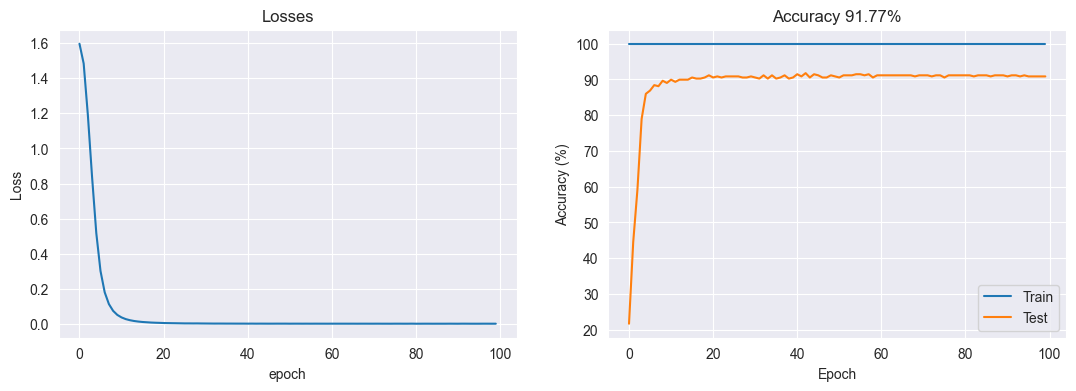

In [214]:

fig, ax = plt.subplots(1, 2, figsize=(13, 4))

ax[0].plot(losses_train)
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('Losses')

ax[1].plot(acc_train, label='Train')
ax[1].plot(acc_val, label='Test')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Epoch')
ax[1].set_title(f'Accuracy {max(acc_val):.2f}%')
ax[1].legend()
plt.show()

In [215]:
max(acc_val)

tensor(91.7683)

In [216]:
model.eval()
text_x, y = next(iter(test_loader))  # extract X,y from test dataloader
with torch.no_grad():  # deactivates autograd
    yHat = model(text_x)
confusion_matrix(torch.argmax(yHat, axis=1), np.argmax(y, axis=1))

print("Accuracy:", accuracy_score(torch.argmax(yHat, axis=1), np.argmax(y, axis=1)))
print(classification_report(torch.argmax(yHat, axis=1), np.argmax(y, axis=1)))
print("Confusion Matrix:\n", confusion_matrix(torch.argmax(yHat, axis=1), np.argmax(y, axis=1)))

Accuracy: 0.9085365853658537
              precision    recall  f1-score   support

           0       0.90      0.93      0.91        69
           1       0.89      0.98      0.93        48
           2       0.87      0.90      0.88        72
           3       0.98      0.90      0.94        51
           4       0.93      0.86      0.89        88

    accuracy                           0.91       328
   macro avg       0.91      0.92      0.91       328
weighted avg       0.91      0.91      0.91       328

Confusion Matrix:
 [[64  0  5  0  0]
 [ 1 47  0  0  0]
 [ 2  0 65  1  4]
 [ 0  2  1 46  2]
 [ 4  4  4  0 76]]
